### Make a HISTO stat

#### RASSP

In [1]:
# load .msp file
from matchms.importing import load_from_msp
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'notebook'

In [35]:
rassp_gen = []
for i in range(10, 20):
    rassp_gen.extend(list(load_from_msp(f"data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-32_{i}.msp", metadata_harmonization=False)))

In [36]:
len(rassp_gen)

10000

In [37]:
rassp_lens = [s.metadata["num_peaks"] for s in rassp_gen]

In [38]:
def make_lens_histog(lens):
    df = pd.DataFrame({"lens": lens})
    df.sort_values("lens", ascending=True, inplace=True)
    return px.histogram(df, x="lens")

make_lens_histog(rassp_lens)

#### NEIMS

In [6]:
def get_num_peaks(d) -> int:
    am = d["attention_mask"]
    return (np.array(am) != 0).sum()

def get_all_num_peaks(path: str):
    counter = 0
    lens = []
    with open(path, "r") as f:
        while True:
            try:
                d = json.loads(f.readline())
                len = get_num_peaks(d)
                lens.append(len)
            except Exception as e:
                print(e)
                break
    return lens

neims_lens = get_all_num_peaks("data/datasets/30M_rassp/neims_gen/30M_rassp_valid.jsonl")

Expecting value: line 1 column 1 (char 0)


In [31]:
print(f"mean: {np.mean(neims_lens)}, std: {np.std(neims_lens)}")
make_lens_histog(neims_lens)

mean: 124.68865629372539, std: 31.735261881196685


### Get rid of some of the RASSP peaks
.. to shift the distribution appropriately

In [20]:
from matchms import Spectrum

def cumsum_filtering(spectrum, max_sum, max_normalize=False):
    """
    Leaves in the spectrum only the biggest peaks with sum of intensities
    just over max_sum.

    Parameters
    ----------
    spectrum : Spectrum
        spectrum to be filtered
    max_sum : float
        maximum sum of intensities of peaks in the spectrum (if sums to 1, basically percentage of 'mass')
    max_normalize : bool, optional
        whether to normalize the intensities by dividing by max intensity, by default True
    """
    mz = spectrum.peaks.mz
    i = spectrum.peaks.intensities
    
    # sort arrays
    index = (-i).argsort() # descending sort
    mz_sorted = mz[index]
    i_sorted = i[index]
    
    # cut off the smallest peaks (according to cumsum)
    cs = np.cumsum(i_sorted)
    cut = np.searchsorted(cs, max_sum) + 1
    mz_sorted = mz_sorted[:cut] # take only the biggest peaks
    i_sorted = i_sorted[:cut]
    
    # sort arrays back
    index = mz_sorted.argsort()
    mz_sorted = mz_sorted[index]
    i_sorted = i_sorted[index]

    if max_normalize:
        i_sorted = i_sorted / i_sorted.max()

    # create new spectrum
    metadata = spectrum.metadata
    metadata["num_peaks"] = len(mz_sorted)
    s = Spectrum(mz=mz_sorted, intensities=i_sorted, metadata=metadata, metadata_harmonization=False)
    assert s.metadata["num_peaks"] == len(mz_sorted)
    return s

In [39]:
# filter rassp and compare histograms
filtered_rassps = {}
for max_sum in [0.98, 0.99, 0.995, 1]:
    filtered_rassps[max_sum] = [cumsum_filtering(s, max_sum, max_normalize=True) for s in tqdm(rassp_gen)]
    filtered_rassp_lens = np.array([s.metadata["num_peaks"] for s in filtered_rassps[max_sum]], dtype=np.int32)
    cut_off  = len(filtered_rassp_lens[filtered_rassp_lens > 200])
    print(f"max_sum: {max_sum}, mean: {np.mean(filtered_rassp_lens)}, std: {np.std(filtered_rassp_lens)}, cut-off: {cut_off/len(filtered_rassp_lens)}%")
    display(make_lens_histog(filtered_rassp_lens))

100%|██████████| 10000/10000 [00:01<00:00, 5812.38it/s]


max_sum: 0.98, mean: 92.5159, std: 28.626465852249385, cut-off: 0.0006%


100%|██████████| 10000/10000 [00:01<00:00, 6827.89it/s]


max_sum: 0.99, mean: 108.6413, std: 30.24929477376291, cut-off: 0.0031%


100%|██████████| 10000/10000 [00:01<00:00, 6750.94it/s]


max_sum: 0.995, mean: 123.7851, std: 30.972699559289307, cut-off: 0.0074%


100%|██████████| 10000/10000 [00:01<00:00, 5619.19it/s]


max_sum: 1, mean: 212.03, std: 24.827954003501777, cut-off: 0.6793%


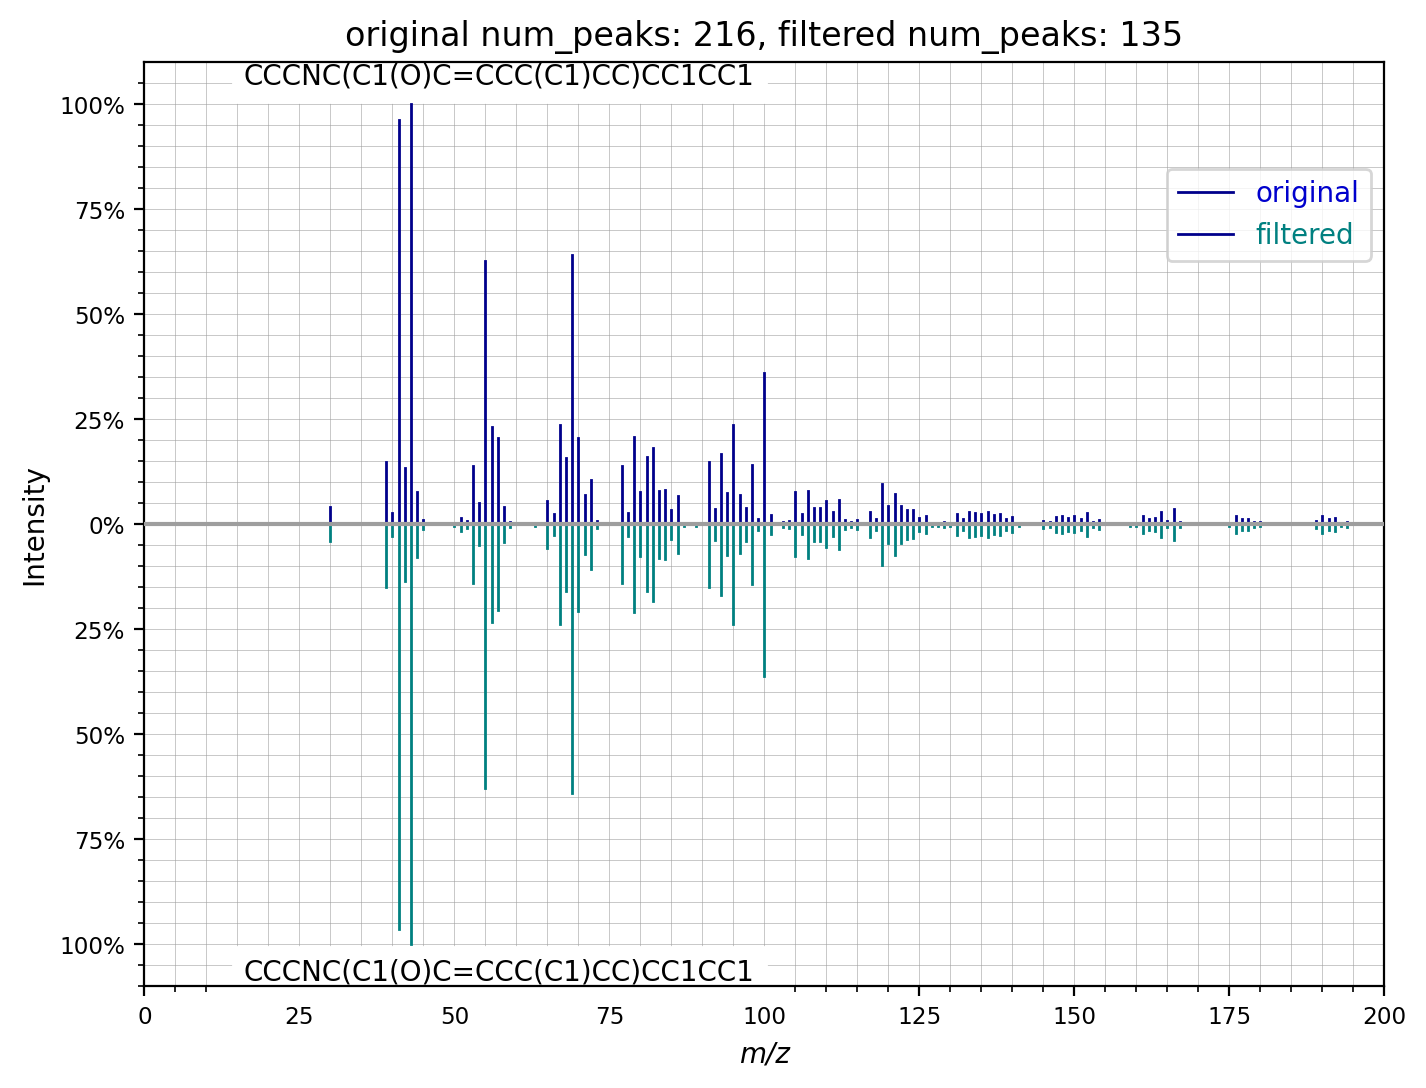

In [51]:
# Visulize the difference between filtered and unfiltered spectra
def compare_filtered_with_original(all_original, all_filtered, max_sum, n):
    rassp_gen[n].plot_against(filtered_rassps[max_sum][n])
    plt.xlim(0, 200)
    plt.title(f'original num_peaks: {rassp_gen[n].metadata["num_peaks"]}, filtered num_peaks: {filtered_rassps[max_sum][n].metadata["num_peaks"]}')
    plt.legend(["original", "filtered"], labelcolor=["mediumblue","teal"], loc='upper right', bbox_to_anchor=(1, 0.9))

n = 31
# ms1 = 0.95
ms2 = 0.995

# compare_filtered_with_original(rassp_gen, filtered_rassps, ms1, n)
compare_filtered_with_original(rassp_gen, filtered_rassps, ms2, n)


# Conclusion
.. I'll use max_sum 0.995 - it has similar mean num_peaks as NEIMS generated spectra while basically NO cuto-ff